In [ ]:
from pathlib import Path
import os
import re
import html
import string

import unicodedata


import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras import losses
from keras import metrics
from keras import optimizers

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:

DATA_PATH=Path('./dat/')
DATA_PATH.mkdir(exist_ok=True)
#if not os.path.exists('./dat/aclImdb_v1.tar.gz'):
if not os.path.exists('./dat/aclImdb'):
    !curl -O http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz 
    !tar -xf aclImdb_v1.tar.gz -C {DATA_PATH}

In [ ]:
import numpy as np
CLASSES = ['neg', 'pos']#, 'unsup']
PATH=Path('./dat/aclImdb/')

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            #texts.append(fixup(fname.open('r', encoding='utf-8').read()))
            texts.append(fname.open('r', encoding='utf-8').read())
            labels.append(idx)
    #return np.array(texts),np.array(labels)
    return texts, labels

trn_texts,trn_labels = get_texts(PATH/'train')
tst_texts,tst_labels = get_texts(PATH/'test')

In [ ]:
for t in trn_texts[:10]:
  print(t)
  #print('\n')

What we have here is a film about how the pursuit of money & revenge can corrupt your soul... or something like that. Guy Ritchie, a director known for his reworking of the gangster genre, bites off more than he can chew with this one.<br /><br />His use of modern film noir to tackle the theme of a man setting himself free by swallowing his pride, being nice to his enemy & giving away all his money falls flat on it's face. When Jason Statham's character no longer fears Ray Liotta, it apparently drives Liotta crazy enough to blow his head off in the final scene. Why? Basically you cannot set up a mafiosi like the Liotta character, who has presumably got to his station in life by displaying the kind of ruthless behaviour evident throughout the film, only then to have him driven to suicide by nothing more than a pitying smile on the face of Statham's character.<br /><br />Before anyone starts to say I'm missing the point... I'm not. I get it OK? Opt out of the quest for riches & you'll fi

In [ ]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()



def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
  return word_tokenize(text)

def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    stop_words = stopwords.words('english')
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem or lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

In [ ]:
def normalize_corpus(corpus):
  return [normalize_text(t) for t in corpus]
  

In [ ]:
trn_texts = normalize_corpus(trn_texts)
tst_texts = normalize_corpus(tst_texts)

In [ ]:
vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
texts = trn_texts + tst_texts
tok.fit_on_texts(texts)

In [ ]:
x_train = tok.texts_to_sequences(trn_texts)
x_test = tok.texts_to_sequences(tst_texts)
y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')

In [ ]:
def get_max_len(texts):
  return max([len(word_tokenize(text)) for text in texts])

def pad_seq(seq, maxlen):  
  return np.array(pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post'))

In [ ]:
#maxlen = get_max_len(texts)
maxlen = 100
x_train = pad_seq(x_train, maxlen)
x_test = pad_seq(x_test, maxlen)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(25000, 100)
(25000, 100)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42, shuffle=True)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM, Conv1D, MaxPooling1D


embedding_size = 100
# Convolution
kernel_size = 5
filters = 64
pool_size = 4



model = Sequential()
#model.add(Embedding(vocab_sz+1, embedding_size, mask_zero=True, input_length=maxlen)) No masking allowed for Conv1D
model.add(Embedding(vocab_sz+1, embedding_size, input_length=maxlen))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
#model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))



model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000100   
                                                                 
 conv1d (Conv1D)             (None, 96, 64)            32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 24, 64)           0         
 )                                                               
                                                                 
 dense (Dense)               (None, 24, 1)             65        
                                                                 
Total params: 1,032,229
Trainable params: 1,032,229
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/gdrive')
gdrive_path = 'gdrive/My Drive/Colab Notebooks/DL NLP Course'

from keras.callbacks import ModelCheckpoint, Callback
model_name = 'basic'
filepath = os.path.join(gdrive_path, 'imdb_lstm_' + model_name + '.h5')
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

Mounted at /content/gdrive


In [ ]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

callbacks_lst = [checkpoint]
# Training
batch_size = 256
epochs = 20
print('Train...')
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,          
          validation_data=(x_val, y_val),
          #validation_split=0.2,
          callbacks=callbacks_lst)

history_dict = history.history
history_dict.keys()

Train...
Epoch 1/20
59/59 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.5006

59/59 [==============================] - 12s 21ms/step - loss: 0.2502 - accuracy: 0.5006 - val_loss: 0.2500 - val_accuracy: 0.4984
Epoch 2/20
57/59 [===========================>..] - ETA: 0s - loss: 0.2501 - accuracy: 0.5009

59/59 [==============================] - 1s 9ms/step - loss: 0.2500 - accuracy: 0.5019 - val_loss: 0.2502 - val_accuracy: 0.4963
Epoch 3/20
57/59 [===========================>..] - ETA: 0s - loss: 0.2501 - accuracy: 0.4983

59/59 [==============================] - 1s 9ms/step - loss: 0.2501 - accuracy: 0.4978 - val_loss: 0.2501 - val_accuracy: 0.4971
Epoch 4/20
55/59 [==========================>...] - ETA: 0s - loss: 0.2501 - accuracy: 0.5006

59/59 [==============================] - 1s 10ms/step - loss: 0.2501 - accuracy: 0.5007 - val_loss: 0.2500 - val_accuracy: 0.5012
Epoch 5/20
59/59 [==============================] - ETA: 0s - loss: 0.2501 - accuracy: 0.4954

59/59 [==============================] - 1s 10ms/step - loss: 0.2501 - accuracy: 0.4954 - val_loss: 0.2500 - val_accuracy: 0.5008
Epoch 6/20
55/59 [==========================>...] - ETA: 0s - loss: 0.2501 - accuracy: 0.5007

59/59 [==============================] - 1s 9ms/step - loss: 0.2501 - accuracy: 0.5004 - val_loss: 0.2501 - val_accuracy: 0.4986
Epoch 7/20
57/59 [===========================>..] - ETA: 0s - loss: 0.2500 - accuracy: 0.4984

59/59 [==============================] - 1s 10ms/step - loss: 0.2500 - accuracy: 0.4987 - val_loss: 0.2500 - val_accuracy: 0.4972
Epoch 8/20
56/59 [===========================>..] - ETA: 0s - loss: 0.2500 - accuracy: 0.4963

59/59 [==============================] - 1s 9ms/step - loss: 0.2500 - accuracy: 0.4965 - val_loss: 0.2500 - val_accuracy: 0.4978
Epoch 9/20
57/59 [===========================>..] - ETA: 0s - loss: 0.2500 - accuracy: 0.5009

59/59 [==============================] - 1s 10ms/step - loss: 0.2500 - accuracy: 0.5011 - val_loss: 0.2500 - val_accuracy: 0.4979
Epoch 10/20
52/59 [=========================>....] - ETA: 0s - loss: 0.2500 - accuracy: 0.4986

59/59 [==============================] - 1s 9ms/step - loss: 0.2500 - accuracy: 0.4973 - val_loss: 0.2500 - val_accuracy: 0.4972
Epoch 11/20
57/59 [===========================>..] - ETA: 0s - loss: 0.2500 - accuracy: 0.5022

59/59 [==============================] - 1s 10ms/step - loss: 0.2500 - accuracy: 0.5019 - val_loss: 0.2500 - val_accuracy: 0.4971
Epoch 12/20
56/59 [===========================>..] - ETA: 0s - loss: 0.2500 - accuracy: 0.5013

59/59 [==============================] - 1s 9ms/step - loss: 0.2500 - accuracy: 0.5012 - val_loss: 0.2500 - val_accuracy: 0.4997
Epoch 13/20
56/59 [===========================>..] - ETA: 0s - loss: 0.2500 - accuracy: 0.4986

59/59 [==============================] - 1s 9ms/step - loss: 0.2500 - accuracy: 0.4990 - val_loss: 0.2501 - val_accuracy: 0.4962
Epoch 14/20
55/59 [==========================>...] - ETA: 0s - loss: 0.2500 - accuracy: 0.5006

59/59 [==============================] - 1s 10ms/step - loss: 0.2500 - accuracy: 0.5007 - val_loss: 0.2500 - val_accuracy: 0.4965
Epoch 15/20
57/59 [===========================>..] - ETA: 0s - loss: 0.2500 - accuracy: 0.5015

59/59 [==============================] - 1s 9ms/step - loss: 0.2500 - accuracy: 0.5017 - val_loss: 0.2500 - val_accuracy: 0.4963
Epoch 16/20
56/59 [===========================>..] - ETA: 0s - loss: 0.2500 - accuracy: 0.5010

59/59 [==============================] - 1s 9ms/step - loss: 0.2500 - accuracy: 0.5018 - val_loss: 0.2500 - val_accuracy: 0.4966
Epoch 17/20
56/59 [===========================>..] - ETA: 0s - loss: 0.2500 - accuracy: 0.5023

59/59 [==============================] - 1s 9ms/step - loss: 0.2500 - accuracy: 0.5024 - val_loss: 0.2500 - val_accuracy: 0.4964
Epoch 18/20
56/59 [===========================>..] - ETA: 0s - loss: 0.2500 - accuracy: 0.5017

59/59 [==============================] - 1s 9ms/step - loss: 0.2500 - accuracy: 0.5018 - val_loss: 0.2500 - val_accuracy: 0.4963
Epoch 19/20
55/59 [==========================>...] - ETA: 0s - loss: 0.2500 - accuracy: 0.5016

59/59 [==============================] - 1s 9ms/step - loss: 0.2500 - accuracy: 0.5024 - val_loss: 0.2500 - val_accuracy: 0.4963
Epoch 20/20
54/59 [==========================>...] - ETA: 0s - loss: 0.2500 - accuracy: 0.5024

59/59 [==============================] - 1s 9ms/step - loss: 0.2500 - accuracy: 0.5024 - val_loss: 0.2500 - val_accuracy: 0.4963


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
print(y_train.shape , y_val.shape)

(15000,) (10000,)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D


embedding_size = 100
# Convolution
kernel_size = 5
filters = 64
pool_size = 4



model = Sequential()
#model.add(Embedding(vocab_sz+1, embedding_size, mask_zero=True, input_length=maxlen)) No masking allowed for Conv1D
model.add(Embedding(vocab_sz+1, embedding_size, input_length=maxlen))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
#model.add(MaxPooling1D(pool_size=pool_size))
model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))



model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000100   
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 64)            32064     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,032,229
Trainable params: 1,032,229
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
from keras.callbacks import EarlyStopping
callbacks_lst = [EarlyStopping(monitor='val_accuracy', mode='max')]
# Training
batch_size = 256
epochs = 20
print('Train...')
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,          
          validation_data=(x_val, y_val),
          #validation_split=0.2,
          callbacks=callbacks_lst)

history_dict = history.history
history_dict.keys()

Train...
Epoch 1/20
59/59 [==============================] - 2s 18ms/step - loss: 0.6637 - accuracy: 0.6865 - val_loss: 0.5811 - val_accuracy: 0.7959
Epoch 2/20
59/59 [==============================] - 1s 9ms/step - loss: 0.4485 - accuracy: 0.8189 - val_loss: 0.3976 - val_accuracy: 0.8225


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

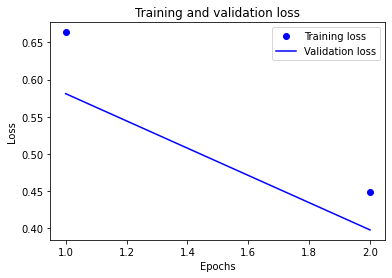

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

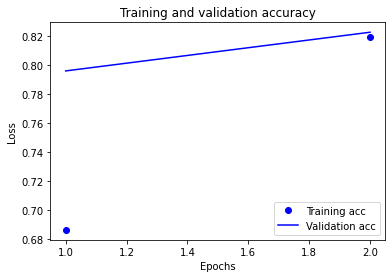

In [ ]:

plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding, Activation
from keras.layers import LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D


embedding_size = 128
# Convolution
kernel_size = 5
filters = 64
pool_size = 4


model = Sequential()
#model.add(Embedding(vocab_sz+1, embedding_size, mask_zero=True, input_length=maxlen)) No masking allowed for Conv1D
#model.add(Embedding(vocab_sz+1, embedding_size, mask_zero=True, input_length=maxlen))
model.add(Embedding(vocab_sz+1, embedding_size, input_length=maxlen))
#model.add(Embedding(20000, embedding_size, input_length=100))
model.add(Dropout(0.2))

model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))

model.add(LSTM(70))
model.add(Dense(1, activation='sigmoid'))



model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 128)          1280128   
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 64)            41024     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 24, 64)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 70)                37800     
                                                                 
 dense_2 (Dense)             (None, 1)                 71        
                                                      

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
from keras.callbacks import EarlyStopping
callbacks_lst = [EarlyStopping(monitor='val_acc', mode='max')]
# Training
batch_size = 256
epochs = 20
print('Train...')
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,          
          validation_data=(x_val, y_val),
          #validation_split=0.2,
          callbacks=callbacks_lst)

history_dict = history.history
history_dict.keys()

Train...
Epoch 1/20
59/59 [==============================] - ETA: 0s - loss: 0.5831 - accuracy: 0.6619

59/59 [==============================] - 6s 33ms/step - loss: 0.5831 - accuracy: 0.6619 - val_loss: 0.3822 - val_accuracy: 0.8342
Epoch 2/20
58/59 [============================>.] - ETA: 0s - loss: 0.2856 - accuracy: 0.8847

59/59 [==============================] - 1s 15ms/step - loss: 0.2854 - accuracy: 0.8850 - val_loss: 0.3425 - val_accuracy: 0.8573
Epoch 3/20
56/59 [===========================>..] - ETA: 0s - loss: 0.1712 - accuracy: 0.9386

59/59 [==============================] - 1s 12ms/step - loss: 0.1744 - accuracy: 0.9369 - val_loss: 0.3692 - val_accuracy: 0.8471
Epoch 4/20
57/59 [===========================>..] - ETA: 0s - loss: 0.1116 - accuracy: 0.9631

59/59 [==============================] - 1s 13ms/step - loss: 0.1123 - accuracy: 0.9627 - val_loss: 0.4248 - val_accuracy: 0.8449
Epoch 5/20
59/59 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9788

59/59 [==============================] - 1s 12ms/step - loss: 0.0700 - accuracy: 0.9788 - val_loss: 0.5186 - val_accuracy: 0.8402
Epoch 6/20
59/59 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.9882

59/59 [==============================] - 1s 12ms/step - loss: 0.0440 - accuracy: 0.9882 - val_loss: 0.5827 - val_accuracy: 0.8377
Epoch 7/20
59/59 [==============================] - ETA: 0s - loss: 0.0255 - accuracy: 0.9935

59/59 [==============================] - 1s 12ms/step - loss: 0.0255 - accuracy: 0.9935 - val_loss: 0.6608 - val_accuracy: 0.8323
Epoch 8/20
55/59 [==========================>...] - ETA: 0s - loss: 0.0241 - accuracy: 0.9936

59/59 [==============================] - 1s 12ms/step - loss: 0.0262 - accuracy: 0.9928 - val_loss: 0.6889 - val_accuracy: 0.8335
Epoch 9/20
56/59 [===========================>..] - ETA: 0s - loss: 0.0181 - accuracy: 0.9959

59/59 [==============================] - 1s 12ms/step - loss: 0.0177 - accuracy: 0.9959 - val_loss: 0.8247 - val_accuracy: 0.8286
Epoch 10/20
58/59 [============================>.] - ETA: 0s - loss: 0.0225 - accuracy: 0.9932

59/59 [==============================] - 1s 12ms/step - loss: 0.0224 - accuracy: 0.9932 - val_loss: 0.7167 - val_accuracy: 0.8381
Epoch 11/20
57/59 [===========================>..] - ETA: 0s - loss: 0.0144 - accuracy: 0.9961

59/59 [==============================] - 1s 12ms/step - loss: 0.0144 - accuracy: 0.9961 - val_loss: 0.6940 - val_accuracy: 0.8317
Epoch 12/20
58/59 [============================>.] - ETA: 0s - loss: 0.0133 - accuracy: 0.9966

59/59 [==============================] - 1s 13ms/step - loss: 0.0133 - accuracy: 0.9966 - val_loss: 0.7653 - val_accuracy: 0.8337
Epoch 13/20
59/59 [==============================] - ETA: 0s - loss: 0.0077 - accuracy: 0.9985

59/59 [==============================] - 1s 13ms/step - loss: 0.0077 - accuracy: 0.9985 - val_loss: 0.8382 - val_accuracy: 0.8254
Epoch 14/20
57/59 [===========================>..] - ETA: 0s - loss: 0.0134 - accuracy: 0.9960

59/59 [==============================] - 1s 12ms/step - loss: 0.0133 - accuracy: 0.9960 - val_loss: 0.8422 - val_accuracy: 0.8315
Epoch 15/20
56/59 [===========================>..] - ETA: 0s - loss: 0.0071 - accuracy: 0.9983

59/59 [==============================] - 1s 13ms/step - loss: 0.0079 - accuracy: 0.9981 - val_loss: 0.8529 - val_accuracy: 0.8325
Epoch 16/20
57/59 [===========================>..] - ETA: 0s - loss: 0.0073 - accuracy: 0.9982

59/59 [==============================] - 1s 13ms/step - loss: 0.0077 - accuracy: 0.9982 - val_loss: 0.9236 - val_accuracy: 0.8325
Epoch 17/20
58/59 [============================>.] - ETA: 0s - loss: 0.0068 - accuracy: 0.9988

59/59 [==============================] - 1s 13ms/step - loss: 0.0068 - accuracy: 0.9988 - val_loss: 0.7912 - val_accuracy: 0.8320
Epoch 18/20
57/59 [===========================>..] - ETA: 0s - loss: 0.0225 - accuracy: 0.9921

59/59 [==============================] - 1s 12ms/step - loss: 0.0221 - accuracy: 0.9923 - val_loss: 0.7840 - val_accuracy: 0.8257
Epoch 19/20
57/59 [===========================>..] - ETA: 0s - loss: 0.0199 - accuracy: 0.9937

59/59 [==============================] - 1s 13ms/step - loss: 0.0196 - accuracy: 0.9937 - val_loss: 0.8061 - val_accuracy: 0.8349
Epoch 20/20
57/59 [===========================>..] - ETA: 0s - loss: 0.0053 - accuracy: 0.9990

59/59 [==============================] - 1s 12ms/step - loss: 0.0057 - accuracy: 0.9990 - val_loss: 0.8532 - val_accuracy: 0.8371


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])